# Unsupervised learning

### The goal of the notebook is to research some models x features sets out of *.pcaps

## SET UP

In [47]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import collections
import seaborn as sns
import pprint
import os
import ipywidgets
import warnings

# import pyshark
# import networkx as nx

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import umap

from itertools import product

# PATH change to access library cyberlib
import sys
sys.path.append('/home/benjamin/Folders_Python/Cyber/libs')
import cyberlib as cbl

# to allow PyShark to run in Jupyter notebooks
# import nest_asyncio
# nest_asyncio.apply()

In [48]:
# logging set-up

lg = cbl.GetLogger('/home/benjamin/Folders_Python/Cyber/logs/unsupervised_learning.log')
logger = lg.get_custom_logger()

# start your engine
logger.info("-------- new run --------")

## Import *.pcap, use tshark to convert to *.csv, then get a raw Pandas DataFrame

### We will look at Ethernet packets part of a TCP conversation

In [49]:
# which *.pcap

DFNAME = 'smallFlows'

PCAPFILE = '/home/benjamin/Folders_Python/Cyber/data/input_pcaps/' + DFNAME + '.pcap'

In [50]:
# We use the tshark CLI to parse the *.pcap file and output a *.csv file for pandas
# doc here : https://www.wireshark.org/docs/man-pages/tshark.html

# tshark :
# -r                :   reads the *.pcap
# -2, -R "tcp"      :   does 2 passes and keeps packets part of TCP conversations only
# -T fields         :   outputs a file with fields
# -E header=y       :   keeps the fields names on first row for pd.read_csv
# -E separator=,    :   for *.csv format
# -e <fields>       :   desired output fields
# -o                :   formats of the data in the fields

cli="tshark -r " + PCAPFILE + """ -2 \
    -R "tcp" \
    -T fields -E header=y -E separator=, \
    -e frame.number -e eth.src -e eth.dst \
    -e ip.src_host -e ip.dst_host -e tcp.flags \
    -e ip.len -e ip.hdr_len -e ip.ttl \
    -e tcp.srcport -e tcp.dstport -e tcp.stream -e tcp.len \
    -e tcp.seq -e tcp.ack -e tcp.hdr_len -e tcp.time_relative \
    -e tcp.time_delta \
    -o 'gui.column.format:"No","%m","Time","%t","Source","%s","Destination","%d","Protocol","%p","Length","%L","Info","%i"' \
    > ~/Folders_Python/Cyber/data/input_pcaps/to_csv/test.csv"""

exit_code = os.system(cli)

if exit_code == 0:
    logger.info('Executed successfully *.pcap to *.csv translation with tshark')
else:
    logger.error('Error while using tshark to translate from *.pcap to *.csv')
    raise NameError('Error while using tshark to translate from *.pcap to *.csv')


In [51]:
# DFNAME = 'exemple'

# PCAPFILE = '/home/benjamin/Folders_Python/Cyber/data/input_pcaps/' + DFNAME + '.pcap'

# capture = pyshark.FileCapture(
#     input_file=PCAPFILE,
#     use_ek=False
# )

# logger.info(f'-- created a capture object in PyShark with pcap file = {PCAPFILE} --')

# pp = pprint.PrettyPrinter(indent=4)

# for id in range(5):
#     p = cbl.PyPacket(capture[id])
#     pp.pprint(p.data)
#     print('-------------')

In [52]:
filename = '/home/benjamin/Folders_Python/Cyber/data/input_pcaps/to_csv/test.csv'

with open(file=filename, encoding='utf-8') as f:
    df_raw = pd.read_csv(
        f,
        header=0,               # using first row as columns names. they are exported by tshark -E header=y
        on_bad_lines='warn'     # if a line does not have the right length, skip it but warn me
        )

In [53]:
df_raw

,frame.number,eth.src,eth.dst,ip.src_host,ip.dst_host,tcp.flags,ip.len,ip.hdr_len,ip.ttl,tcp.srcport,tcp.dstport,tcp.stream,tcp.len,tcp.seq,tcp.ack,tcp.hdr_len,tcp.time_relative,tcp.time_delta
0,1,40:61:86:9a:f1:f5,00:1a:8c:15:f9:80,192.168.3.131,72.14.213.138,0x0018,983,20,128,57011,80,0,943,1,1,20,0.000000,0.000000
1,2,00:1a:8c:15:f9:80,40:61:86:9a:f1:f5,72.14.213.138,192.168.3.131,0x0018,426,20,52,80,57011,0,386,1,944,20,0.029841,0.029841
2,3,40:61:86:9a:f1:f5,00:1a:8c:15:f9:80,192.168.3.131,72.14.213.102,0x0002,52,20,128,55950,80,1,0,0,0,32,0.000000,0.000000
3,4,40:61:86:9a:f1:f5,00:1a:8c:15:f9:80,192.168.3.131,72.14.213.138,0x0010,40,20,128,57011,80,0,0,944,387,20,0.229423,0.199582
4,5,00:1a:8c:15:f9:80,40:61:86:9a:f1:f5,72.14.213.102,192.168.3.131,0x0012,52,20,52,80,55950,1,0,0,1,32,0.018766,0.018766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13703,13704,08:00:27:cc:3f:1b,52:54:00:12:35:02,10.0.2.15,65.55.15.244,0x0014,40,20,128,2537,5480,407,0,5039,5738,20,71.195375,66.560501
13704,13705,08:00:27:cc:3f:1b,52:54:00:12:35:02,10.0.2.15,207.46.105.186,0x0014,40,20,128,2540,5480,409,0,398,93,20,70.606228,5.540471
13705,13706,08:00:27:cc:3f:1b,52:54:00:12:35:02,10.0.2.15,96.17.8.49,0x0014,40,20,128,2547,5480,419,0,496,8189,20,64.405045,64.259982
13706,13707,08:00:27:cc:3f:1b,52:54:00:12:35:02,10.0.2.15,91.103.140.2,0x0014,40,20,128,2546,5480,417,0,525,270,20,64.884164,64.357688


In [54]:
df_raw.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
frame.number,13708.0,NaN,NaN,NaN,6854.5,3957.30308,1.0,3427.75,6854.5,10281.25,13708.0
eth.src,13708,7,00:1a:8c:15:f9:80,6166,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eth.dst,13708,7,40:61:86:9a:f1:f5,6172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ip.src_host,13708,106,192.168.3.131,4257,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ip.dst_host,13708,110,192.168.3.131,6172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tcp.flags,13708,8,0x0010,8622,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ip.len,13708.0,NaN,NaN,NaN,651.767435,667.587111,40.0,40.0,184.0,1500.0,1500.0
ip.hdr_len,13708.0,NaN,NaN,NaN,20.0,0.0,20.0,20.0,20.0,20.0,20.0
ip.ttl,13708.0,NaN,NaN,NaN,111.141304,60.890005,46.0,54.0,128.0,128.0,245.0
tcp.srcport,13708.0,NaN,NaN,NaN,19262.756566,25557.152425,80.0,80.0,443.0,56055.0,61863.0


In [55]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13708 entries, 0 to 13707
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   frame.number       13708 non-null  int64  
 1   eth.src            13708 non-null  object 
 2   eth.dst            13708 non-null  object 
 3   ip.src_host        13708 non-null  object 
 4   ip.dst_host        13708 non-null  object 
 5   tcp.flags          13708 non-null  object 
 6   ip.len             13708 non-null  int64  
 7   ip.hdr_len         13708 non-null  int64  
 8   ip.ttl             13708 non-null  int64  
 9   tcp.srcport        13708 non-null  int64  
 10  tcp.dstport        13708 non-null  int64  
 11  tcp.stream         13708 non-null  int64  
 12  tcp.len            13708 non-null  int64  
 13  tcp.seq            13708 non-null  int64  
 14  tcp.ack            13708 non-null  int64  
 15  tcp.hdr_len        13708 non-null  int64  
 16  tcp.time_relative  137

In [56]:
# Saves the raw DataFrame

DIRDATAFRAMES = '/home/benjamin/Folders_Python/Cyber/data/dataframes/'
filename = DIRDATAFRAMES + 'df_raw_' + DFNAME + '.pkl'

if os.path.isfile(filename):
    df_raw = pd.read_pickle(filename)
    logger.info('read an existing dataframe for unsupervised learning')
else:
    # df_raw = cbl.GetTCPDataframeFromFileCapture(filecapture=capture).dataframe
    df_raw.to_pickle(filename)
    logger.info('created and wrote a dataframe for unsupervised learning')

In [57]:
df_raw

,frame.number,eth.src,eth.dst,ip.src_host,ip.dst_host,tcp.flags,ip.len,ip.hdr_len,ip.ttl,tcp.srcport,tcp.dstport,tcp.stream,tcp.len,tcp.seq,tcp.ack,tcp.hdr_len,tcp.time_relative,tcp.time_delta
0,1,40:61:86:9a:f1:f5,00:1a:8c:15:f9:80,192.168.3.131,72.14.213.138,0x0018,983,20,128,57011,80,0,943,1,1,20,0.000000,0.000000
1,2,00:1a:8c:15:f9:80,40:61:86:9a:f1:f5,72.14.213.138,192.168.3.131,0x0018,426,20,52,80,57011,0,386,1,944,20,0.029841,0.029841
2,3,40:61:86:9a:f1:f5,00:1a:8c:15:f9:80,192.168.3.131,72.14.213.102,0x0002,52,20,128,55950,80,1,0,0,0,32,0.000000,0.000000
3,4,40:61:86:9a:f1:f5,00:1a:8c:15:f9:80,192.168.3.131,72.14.213.138,0x0010,40,20,128,57011,80,0,0,944,387,20,0.229423,0.199582
4,5,00:1a:8c:15:f9:80,40:61:86:9a:f1:f5,72.14.213.102,192.168.3.131,0x0012,52,20,52,80,55950,1,0,0,1,32,0.018766,0.018766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13703,13704,08:00:27:cc:3f:1b,52:54:00:12:35:02,10.0.2.15,65.55.15.244,0x0014,40,20,128,2537,5480,407,0,5039,5738,20,71.195375,66.560501
13704,13705,08:00:27:cc:3f:1b,52:54:00:12:35:02,10.0.2.15,207.46.105.186,0x0014,40,20,128,2540,5480,409,0,398,93,20,70.606228,5.540471
13705,13706,08:00:27:cc:3f:1b,52:54:00:12:35:02,10.0.2.15,96.17.8.49,0x0014,40,20,128,2547,5480,419,0,496,8189,20,64.405045,64.259982
13706,13707,08:00:27:cc:3f:1b,52:54:00:12:35:02,10.0.2.15,91.103.140.2,0x0014,40,20,128,2546,5480,417,0,525,270,20,64.884164,64.357688


### Preprocessing : ordinal encoding, normalization

In [58]:
# ordinal encoding with Pandas

columns_to_encode_as_ordinal = ['frame.number', 'eth.src', 'eth.dst', 'ip.src_host', 'ip.dst_host', 'tcp.flags']

df_ord = pd.DataFrame()
for c in columns_to_encode_as_ordinal:
    codes, _ = pd.factorize(df_raw[c])
    df_sup = pd.DataFrame(data={ c : list(codes) })
    df_ord = pd.concat([df_ord, df_sup], axis=1)
    
df = df_raw.drop(columns=columns_to_encode_as_ordinal)
df.reset_index(drop=True)

df = pd.concat([df, df_ord], axis=1)

# columns_to_drop = ['TIMESTAMP_ts']
# df.drop(columns=columns_to_drop, inplace=True)

df

,ip.len,ip.hdr_len,ip.ttl,tcp.srcport,tcp.dstport,tcp.stream,tcp.len,tcp.seq,tcp.ack,tcp.hdr_len,tcp.time_relative,tcp.time_delta,frame.number,eth.src,eth.dst,ip.src_host,ip.dst_host,tcp.flags
0,983,20,128,57011,80,0,943,1,1,20,0.000000,0.000000,0,0,0,0,0,0
1,426,20,52,80,57011,0,386,1,944,20,0.029841,0.029841,1,1,1,1,1,0
2,52,20,128,55950,80,1,0,0,0,32,0.000000,0.000000,2,0,0,0,2,1
3,40,20,128,57011,80,0,0,944,387,20,0.229423,0.199582,3,0,0,0,0,2
4,52,20,52,80,55950,1,0,0,1,32,0.018766,0.018766,4,1,1,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13703,40,20,128,2537,5480,407,0,5039,5738,20,71.195375,66.560501,13703,4,4,48,68,5
13704,40,20,128,2540,5480,409,0,398,93,20,70.606228,5.540471,13704,4,4,48,70,5
13705,40,20,128,2547,5480,419,0,496,8189,20,64.405045,64.259982,13705,4,4,48,82,5
13706,40,20,128,2546,5480,417,0,525,270,20,64.884164,64.357688,13706,4,4,48,80,5


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13708 entries, 0 to 13707
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ip.len             13708 non-null  int64  
 1   ip.hdr_len         13708 non-null  int64  
 2   ip.ttl             13708 non-null  int64  
 3   tcp.srcport        13708 non-null  int64  
 4   tcp.dstport        13708 non-null  int64  
 5   tcp.stream         13708 non-null  int64  
 6   tcp.len            13708 non-null  int64  
 7   tcp.seq            13708 non-null  int64  
 8   tcp.ack            13708 non-null  int64  
 9   tcp.hdr_len        13708 non-null  int64  
 10  tcp.time_relative  13708 non-null  float64
 11  tcp.time_delta     13708 non-null  float64
 12  frame.number       13708 non-null  int64  
 13  eth.src            13708 non-null  int64  
 14  eth.dst            13708 non-null  int64  
 15  ip.src_host        13708 non-null  int64  
 16  ip.dst_host        137

In [60]:
# the rest of the preprocessing with a scikit learn pipeline

pipe = Pipeline(
    [ ('normalize', StandardScaler() )]
)

In [61]:
X = df.to_numpy()
X_norm = pipe.fit_transform(X)

In [62]:
X_norm.shape

(13708, 18)

### Vizualization : PCA, t-SNE

In [63]:
def viz3d(X_embedding, titre='visu 3D'):
    """Utility function to plot a 3D picture

    Args:
        X_embedding (_type_): _description_
    """
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection='3d')
    
    xs = X_embedding[:,0]
    ys = X_embedding[:,1]
    zs = X_embedding[:,2]
    
    ax.scatter3D(xs, ys, zs)
    ax.set_title(titre)
    
    plt.show()
    
    return fig, ax

Variance per principal component : ['22.2%', '16.5%', '12.6%']%


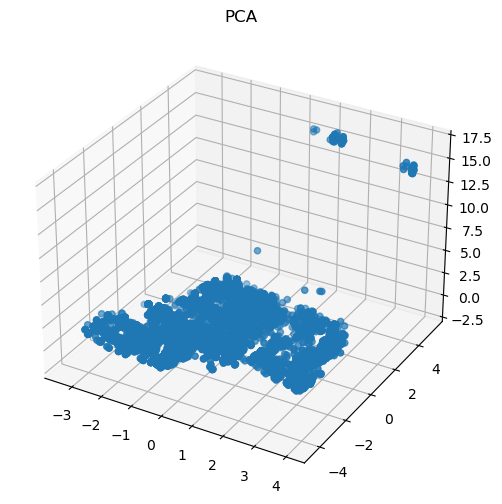

In [64]:
pca = PCA(
    n_components = 3
)

X_new = pca.fit_transform(X_norm)

expl = [ r*100 for r in pca.explained_variance_ratio_ ]
expl_s = [ f'{e:.1f}%' for e in expl ]
print(f'Variance per principal component : {expl_s}%')

viz3d(X_new, 'PCA')
plt.show()

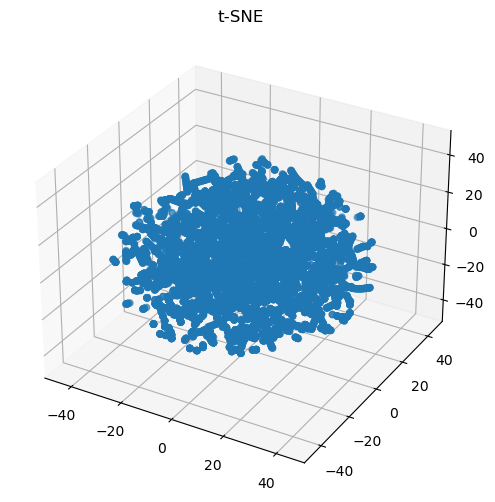

In [65]:
X_new = TSNE(
    n_components=3, 
    learning_rate='auto',
    perplexity=10  # related to the number of neighbors used in other manifold learning algorithms. Highly sensitve parameter.
    ).fit_transform(X_norm)

viz3d(X_new, 't-SNE')
plt.show()

### Clustering

k-means

In [67]:
# finding a good number of clusters

MAX_CLUSTERS = 100
range_clusters = range(2, MAX_CLUSTERS+1, 10)

silhouette = np.zeros(shape=(MAX_CLUSTERS-1))

for n_clusters in range_clusters:
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        init='k-means++', # educated attempt to have a good initialization
        n_init=1  # because k-means++
        )
    labels = kmeans.fit_predict(X_norm)
    silhouette[n_clusters-2] = silhouette_score(X_norm, labels)
    print(f'Silhouette score for {n_clusters} clusters = {silhouette[n_clusters-2]}')
    
n_cluster_opt = np.argmax(silhouette) + 2
print(f'Nb clusters retenu = {n_cluster_opt}')

Silhouette score for 2 clusters = 0.18138963806705644
Silhouette score for 12 clusters = 0.3633297382312125
Silhouette score for 22 clusters = 0.45358636651358053
Silhouette score for 32 clusters = 0.4998047300685446
Silhouette score for 42 clusters = 0.5238296509732621
Silhouette score for 52 clusters = 0.5024838101613986
Silhouette score for 62 clusters = 0.5546324838604028
Silhouette score for 72 clusters = 0.553968599173549
Silhouette score for 82 clusters = 0.5326926287541395
Silhouette score for 92 clusters = 0.5172645429668934
Nb clusters retenu = 62


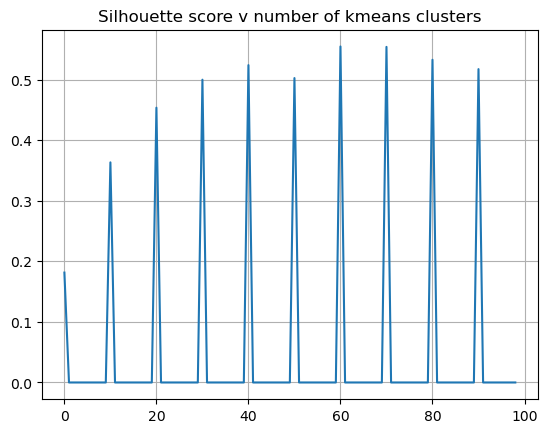

In [68]:
fig, ax = plt.subplots()

ax.plot(silhouette)
ax.grid(True)
ax.set_title('Silhouette score v number of kmeans clusters')
plt.show()

In [69]:
kmeans = KMeans(
    n_clusters=n_cluster_opt,
    random_state=0,
    init='k-means++', # educated attempt to have a good initialization
    n_init=1  # because k-means++
)

In [70]:
def visu3d(X_norm=X_norm, model=None, labels=None, titre='Visu 3d'):
    """Utility function to plot the 3d PCA projection of the trained model with clusters labels

    Args:
        X_norm (_type_, optional): _description_. Defaults to X_norm.
        model (_type_, optional): _description_. Defaults to None.
        labels (_type_, optional): _description_. Defaults to None.
    """
    
    unique_labels = np.unique(labels)
    
    pca = PCA(n_components = 3)
    X_embedding = pca.fit_transform(X_norm)
    
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection='3d')

    xs = X_embedding[:,0]
    ys = X_embedding[:,1]
    zs = X_embedding[:,2]

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    c = [ colors[labels[i]] if labels[i] >= 0 else [0,0,0,1] for i in range(len(labels)) ]
        
    ax.scatter3D(xs, ys, zs, color=c)
    n_clusters = len(set(unique_labels)) - (1 if -1 in labels else 0)
    titre = titre + f' {n_clusters} clusters'
    ax.set_title(titre)
        
    plt.show()
    
    return fig, ax

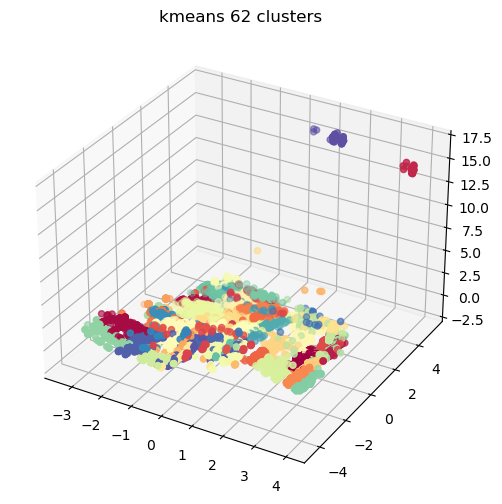

In [71]:
labels = kmeans.fit_predict(X_norm)

fig, ax = visu3d(
    X_norm=X_norm,
    model=kmeans,
    labels=kmeans.fit_predict(X_norm),
    titre=f'kmeans'
)

DBSCAN

In [73]:
# finding a good pair of Epsilon x Min_samples parameters

# epsilons
distances = pairwise_distances(X_norm, X_norm).flatten() # compute all the euclidian distances between two points in X_norm
dmax = np.max(distances)
print(f'max distance between two points in feature space = {dmax}')
N_EPSILONS = 3
epsilons_range = np.linspace(dmax/100.0, dmax/20.0, num=N_EPSILONS)
# print(epsilons_range)

# minimum samples
n_samples = X_norm.shape[0]
N_MIN_SAMPLES = 5
n_min_samples = np.max( [2,n_samples/2000] )
n_max_samples = np.max( [n_samples/100, n_min_samples+1] )
min_samples_range = np.linspace(n_min_samples, n_max_samples, num=N_MIN_SAMPLES).astype('int')
# print(min_samples_range)

# silhouettes calculations
silhouette_max = -1.0

for epsilon, min_samples in product(epsilons_range, min_samples_range):
    print(f'-----------------------------------------------------')
    print(f'n_samples = {min_samples}, epsilon = {epsilon}')
    
    db = DBSCAN(
        eps=epsilon,
        min_samples=min_samples
        )
    
    labels = db.fit_predict(X_norm)
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  # number of found clusters (without -1 which is the label for noise
    n_noise_ = list(labels).count(-1)  # number of noisy points
    noise_ratio = n_noise_/n_samples
    
    print(f'number of clusters found is {n_clusters_}')
    print(f'number of noise points found is {n_noise_} out of {n_samples} total (ie {noise_ratio*100:.2f}%)')
    
    if len(set(labels)) >= 2:
        s = silhouette_score(X_norm, labels)
        print(f'Silhouette score for {n_clusters_} clusters = {s:.3f}')
    else:
        print(f'Not calulating silhouette score as only one label found')
    
    if s > silhouette_max:
        silhouette_max = s
        opt_n_clusters = n_clusters_
        opt_eps = epsilon
        opt_min_samples = min_samples
        opt_noise_ratio = noise_ratio
        
print(f'====================================================================================================')
print(f'Best silhouette score is {silhouette_max} with {opt_n_clusters} clusters and {opt_noise_ratio*100:.2f}% noise, for epsilon = {opt_eps} and min_samples = {opt_min_samples}')

max distance between two points in feature space = 44.00603577943084
-----------------------------------------------------
n_samples = 6, epsilon = 0.4400603577943084
number of clusters found is 182
number of noise points found is 1289 out of 13708 total (ie 9.40%)
Silhouette score for 182 clusters = 0.355
-----------------------------------------------------
n_samples = 39, epsilon = 0.4400603577943084
number of clusters found is 49
number of noise points found is 4724 out of 13708 total (ie 34.46%)
Silhouette score for 49 clusters = 0.198
-----------------------------------------------------
n_samples = 71, epsilon = 0.4400603577943084
number of clusters found is 20
number of noise points found is 6950 out of 13708 total (ie 50.70%)
Silhouette score for 20 clusters = 0.074
-----------------------------------------------------
n_samples = 104, epsilon = 0.4400603577943084
number of clusters found is 13
number of noise points found is 7861 out of 13708 total (ie 57.35%)
Silhouette scor

In [74]:
print(f'Running DBSCAN with epsilon = {opt_eps} and min_samples = {opt_min_samples}.\nSilhouette score is {silhouette_max} with {opt_n_clusters} clusters and {opt_noise_ratio*100:.2f}% noise')

db = DBSCAN(
    eps=opt_eps,
    min_samples=opt_min_samples
)

labels = db.fit_predict(X_norm)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  # number of found clusters (without -1 which is the label for noise)
n_noise_ = list(labels).count(-1)  # number of noisy points
n_points = X_norm.shape[0]

print(f'=> number of clusters found is {n_clusters_}')
print(f'=> number of noise points found is {n_noise_} out of {n_points} total (ie {n_noise_/n_points*100:.2f}%)')

Running DBSCAN with epsilon = 0.4400603577943084 and min_samples = 6.
Silhouette score is 0.3548256546948964 with 182 clusters and 9.40% noise
=> number of clusters found is 182
=> number of noise points found is 1289 out of 13708 total (ie 9.40%)


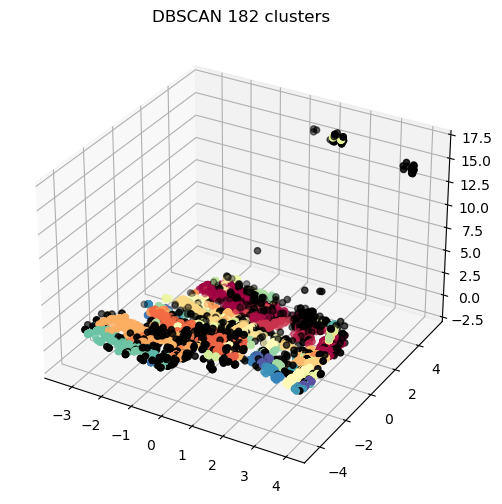

In [75]:
labels = db.fit_predict(X_norm)

fig, ax = visu3d(
    X_norm=X_norm,
    model=db,
    labels=db.fit_predict(X_norm),
    titre=f'DBSCAN'
)

### Gaussian Mixtures

In [76]:
N_MAX_GAUSSIANS = 100
ng_bics = []
bics = []

for i in range(1, N_MAX_GAUSSIANS, 10):
    n_gaussians = i+1
    gm = GaussianMixture(
        n_components=n_gaussians,
        covariance_type='full',
        random_state=42
        )
    
    labels = gm.fit_predict(X_norm)
    bic = gm.bic(X_norm)
    print(f'Model with {n_gaussians} gaussian(s) : BIC score = {bic:.0f}')
    
    ng_bics.append(n_gaussians)
    bics.append(bic)
    
opt_n_gaussians = ng_bics[np.argmin(bics)]
print(f'Best BIC score with {opt_n_gaussians}')

# BIC : https://scikit-learn.org/stable/modules/linear_model.html#aic-bic

Model with 2 gaussian(s) : BIC score = -303220
Model with 12 gaussian(s) : BIC score = -1372351
Model with 22 gaussian(s) : BIC score = -1543920
Model with 32 gaussian(s) : BIC score = -1645829
Model with 42 gaussian(s) : BIC score = -1727062
Model with 52 gaussian(s) : BIC score = -1784095
Model with 62 gaussian(s) : BIC score = -1763559
Model with 72 gaussian(s) : BIC score = -1783253
Model with 82 gaussian(s) : BIC score = -1795132
Model with 92 gaussian(s) : BIC score = -1829915
Best BIC score with 92


Best BIC score -1829915 with 92 gaussians


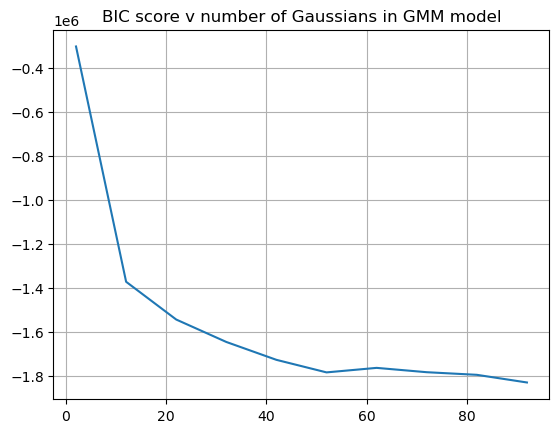

In [77]:
opt_n_gaussians = ng_bics[np.argmin(bics)]
print(f'Best BIC score {np.min(bics):.0f} with {opt_n_gaussians} gaussians')

fig, ax = plt.subplots()

ax.plot(ng_bics, bics)
ax.grid(True)
ax.set_title(f'BIC score v number of Gaussians in GMM model')
plt.show()

In [78]:
gm = GaussianMixture(
    n_components=opt_n_gaussians,
    covariance_type='full',
    random_state=42
)

labels = gm.fit_predict(X_norm)

print(f'BIC score = {gm.bic(X_norm):.2f}')

BIC score = -1829914.84


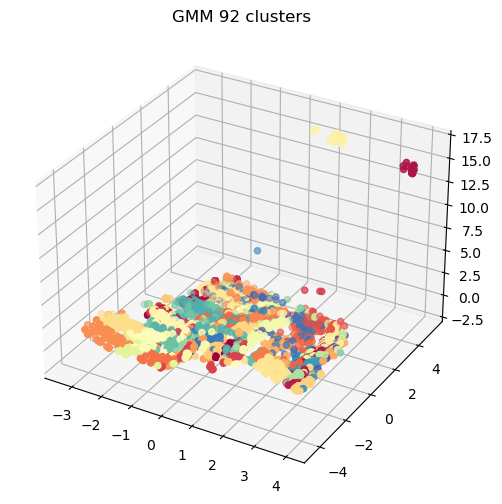

In [79]:
fig, ax = visu3d(
    X_norm=X_norm,
    model=gm,
    labels=labels,
    titre=f'GMM'
)

### UMAP : Manifold Learning => ~ visualization

In [80]:
# DOC : https://umap.scikit-tda.org/index.html

def visu_umap(
    n_neighbors=10,
    min_dist=0.1,
    # X_norm=X_norm
):
    """Utility function to use UMAP for 3D visualization

    Args:
        n_neighbors (int, optional): _description_. Defaults to 10.
        n_components (int, optional): _description_. Defaults to 3.
        min_dist (float, optional): _description_. Defaults to 0.1.
        random_state (int, optional): _description_. Defaults to 42.
    """
    
    warnings.filterwarnings("ignore")
    
    umap_instance = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=3,
        min_dist=min_dist,
        random_state=42
        )
    
    X_new = umap_instance.fit_transform(X_norm)
    
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection='3d')

    xs = X_new[:,0]
    ys = X_new[:,1]
    zs = X_new[:,2]
            
    ax.scatter3D(xs, ys, zs) #, color=c)
    titre = f'UMAP - {n_neighbors} neigbhors, {min_dist} min dist'
    ax.set_title(titre)
            
    plt.show()
    
    # return fig, ax

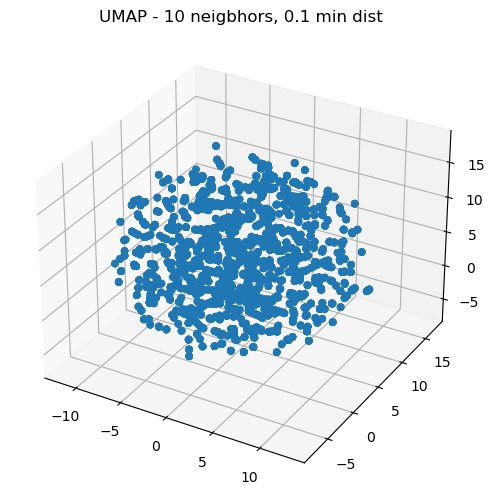

In [81]:
warnings.filterwarnings("ignore")
visu_umap()

In [82]:
ipywidgets.interact(
    visu_umap,
    n_neighbors = (5,100,10),
    min_dist = (0.1,1.0,0.05)
)

interactive(children=(IntSlider(value=10, description='n_neighbors', min=5, step=10), FloatSlider(value=0.1, d…

<function __main__.visu_umap(n_neighbors=10, min_dist=0.1)>